# Problem definition and backgroud

As defined by the Oxford dictionary fraud is "wrongful or criminal deception intended to result in financial or personal gain". Even if fraud is not something new, the phenomenon grew with the increase of internet transactions. When we say transactions, we are not referring strictly to the online payments, even if that is one of the most popular types of online frauds.

For this example, we are using a dataset that contains insurance claims, and each transaction includes the information if it was a fraudulent claim or not

## Goals
- read the data
- understand the data using charts and metrics
- prepare the data for building a classification model
- use Machine Learning algorithms to build a classifier
- use the model to detect fraudulent claims

### Import necessary libraries to process the data

Details for loading libraries and reading the data at [Import and read data details](https://github.com/datagridsoftware/practical-ml/blob/main/docs/import_data_read.md)


In [ ]:
import pandas as pd
import numpy as np

#graphic libs
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# train test split
from sklearn.model_selection import train_test_split

# classifiers
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# classification metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc

from IPython.display import display

pd.set_option('display.max_columns', None) # by default the number of columns shown is trucated. This option will enabe "show all" feature

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read the dataset

Source: https://www.kaggle.com/datasets/incarnyx/car-insurance-fraud

In [ ]:
dataset = pd.read_excel("car_insurance_fraud.xlsx")
dataset.head()

### Data exploration
The purpose of this step is to understand the data, the structure of it, to be able to modify it later to fi the purpose of the experiment. A lot of insights related to the data can be obtain here.

The `describe` function gives an insight on the data by generating statistics on the numeric columns, like count, average, min , max, etc.

For more information, see [Data exploration](https://github.com/datagridsoftware/practical-ml/blob/main/docs/data_exploration.md)

In [ ]:
# numerical features in the dataset
dataset.describe(exclude="object").transpose()

In [ ]:
# non numerical features show different stats
dataset.describe(exclude="number").transpose()

For details about displaying information from the data refer to [Data plotting](https://github.com/datagridsoftware/practical-ml/blob/main/docs/ploting_data.md)

In [ ]:
# Plots the histogram for each numerical feature in a separate subplot
def createHistogramPlot(data):
    data.hist(bins=25, figsize=(30, 25), layout=(-1, 3))
    plt.tight_layout()     

In [ ]:
createHistogramPlot(dataset)

In [ ]:
dataset.plot(lw=0, marker="*", subplots=True, markersize=0.6, figsize=(15, 30))

In [ ]:
df_filtered = dataset.copy()
df_filtered[['Age']].boxplot(figsize=(15, 10))

In [ ]:
g = sns.FacetGrid(dataset, hue='FraudFound_P', height = 7, aspect = 2)
g.map(sns.kdeplot, 'Age')
plt.title('Age distribution for fraud and no fraud claims')
plt.legend()
plt.show()

In [ ]:
g = sns.FacetGrid(dataset, hue='FraudFound_P', height = 7, aspect = 2)
g.map(sns.kdeplot, 'ClaimSize')
plt.title('ClaimSize distribution for fraud and no fraud claims')
plt.legend()
plt.show()

### Data preparation
- resolve issues with the data
- prepare data for training the model

More information on data preparation techniques in [Data preparation](https://github.com/datagridsoftware/practical-ml/blob/main/docs/data_preparation.md)

In [ ]:
dataset.info()

In [ ]:
## Search for null values in the data
null_values = dataset.isnull().sum()
null_values[null_values > 0]

#### Interpolation for null values

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html

In [ ]:
df_interpolation = dataset.copy()

age_index = df_interpolation[df_interpolation['Age'].isnull()].index.tolist()
driver_index = df_interpolation[df_interpolation['DriverRating'].isnull()].index.tolist()

ds_linear = df_interpolation.interpolate(method="linear")
ds_poly = df_interpolation.interpolate(method="polynomial", order=2)
ds_padding = df_interpolation.interpolate(method="pad", limit=3)

age_replacement = { 
    'Linear': ds_linear.iloc[age_index]['Age'], 
    'Polynomial': ds_poly.iloc[age_index]['Age'], 
    'Padding': ds_padding.iloc[age_index]['Age']
}
display( pd.DataFrame(age_replacement))

dr_replacement = { 
    'Linear': ds_linear.iloc[driver_index]['DriverRating'], 
    'Polynomial': ds_poly.iloc[driver_index]['DriverRating'], 
    'Padding': ds_padding.iloc[driver_index]['DriverRating']
}
display(pd.DataFrame(dr_replacement))

#### Imputation for null values

https://www.britannica.com/science/mean-median-and-mode

In [ ]:
df_imputation = dataset.copy()

age_index = df_imputation[df_imputation['Age'].isnull()].index.tolist()
driver_index = df_imputation[df_imputation['DriverRating'].isnull()].index.tolist()

#Mode
ds_mode = df_imputation.copy()
ds_mode['Age'].fillna(ds_mode['Age'].mode()[0], inplace=True)
ds_mode['DriverRating'].fillna(ds_mode['DriverRating'].mode()[0], inplace=True)

#Median
ds_median = df_imputation.copy()
ds_median['Age'].fillna(ds_median['Age'].median(), inplace=True)
ds_median['DriverRating'].fillna(ds_median['DriverRating'].median(), inplace=True)

#Mean
ds_mean = df_imputation.copy()
ds_mean['Age'].fillna(ds_mean['Age'].mean(), inplace=True)
ds_mean['DriverRating'].fillna(ds_mean['DriverRating'].mean(), inplace=True)

age_replacement = { 
    'Mode': ds_mode.iloc[age_index]['Age'], 
    'Median': ds_median.iloc[age_index]['Age'], 
    'Mean': ds_mean.iloc[age_index]['Age']
}
display( pd.DataFrame(age_replacement))

dr_replacement = { 
    'Mode': ds_mode.iloc[driver_index]['DriverRating'], 
    'Median': ds_median.iloc[driver_index]['DriverRating'], 
    'Mean': ds_mean.iloc[driver_index]['DriverRating']
}
display(pd.DataFrame(dr_replacement))

#### SK Imputation

In [ ]:
df_sk_imputation = dataset.copy()

age_index = df_sk_imputation[df_sk_imputation['Age'].isnull()].index.tolist()
driver_index = df_sk_imputation[df_sk_imputation['DriverRating'].isnull()].index.tolist()

# possible values for strategy are mean, media, most_frequent and constant
imputer_simple = SimpleImputer(missing_values=np.NaN,strategy='most_frequent') 
simple_imputer_arr = imputer_simple.fit_transform(df_sk_imputation[['Age', 'DriverRating']])

# k-Nearest Neighbors
imputer_knn = KNNImputer(n_neighbors=2)
knn_arr = imputer_knn.fit_transform(df_sk_imputation[['Age', 'DriverRating']])

age_replacement = { 
    'Simple': simple_imputer_arr[age_index, 0], 
    'KNN': knn_arr[age_index, 0]
}
display( pd.DataFrame(age_replacement))

dr_replacement = { 
    'Simple': simple_imputer_arr[driver_index, 1], 
    'KNN': knn_arr[driver_index, 1]
}
display(pd.DataFrame(dr_replacement))

#### Drop Null Values

In [ ]:
# drop records that have null values
dataset_nn = dataset.dropna(inplace=False)
dataset_nn.isnull().sum() 

In [ ]:
# list number of uniques values for each columns
dataset_nn.nunique()

#### Anomaly in MonthClaimed and DayOfWeekClaimed features?

In [ ]:
#list possible values for MonthClaimed
display(dataset_nn["MonthClaimed"].unique())
display(dataset_nn["DayOfWeekClaimed"].unique())

In [ ]:
display((dataset_nn[dataset_nn["MonthClaimed"] == 0]))
display((dataset_nn[dataset_nn["DayOfWeekClaimed"] == 0]))

In [ ]:
#remove the record where MonthClaimed or DayOfWeekClaimed is equal to 0
zero_feature_index = dataset_nn[(dataset_nn["MonthClaimed"] == 0) | (dataset_nn["DayOfWeekClaimed"] == 0)].index
df_prep = dataset_nn.drop(zero_feature_index)
df_prep.nunique()

### Classifier encoding

#### Manual encoding

In [ ]:
#prepare the dataset for  exploratory data anslisys and model building
months_array = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec']
week_array =['Monday','Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
number_claimed = ['none', '1', '2 to 4', 'more than 4']

df_manual_transform = df_prep.copy()
df_manual_transform['Month'].replace(months_array, [1,2,3,4,5,6,7,8,9,10,11,12], inplace=True)
df_manual_transform['MonthClaimed'].replace(months_array, [1,2,3,4,5,6,7,8,9,10,11,12], inplace=True)
df_manual_transform['DayOfWeek'].replace(week_array, [1,2,3,4,5,6,7], inplace=True)
df_manual_transform['DayOfWeekClaimed'].replace(week_array, [1,2,3,4,5,6,7], inplace=True)
df_manual_transform['PastNumberOfClaims'].replace(number_claimed, [0,1,2,3], inplace=True)

df_manual_transform.head()

####  OrdinalEncoder

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
categorical_columns = df_prep.columns[df_prep.dtypes == object]

df_encoded = df_prep.copy()
enc_values = encoder.fit_transform(df_encoded[categorical_columns].astype(str))
df_encoded[categorical_columns] = enc_values

X_encoded=df_encoded.drop("FraudFound_P", axis = 1)
y_encoded=df_encoded["FraudFound_P"] 

df_encoded.head()

In [ ]:
display(encoder.categories_)

#### One Hot Encoding

In [ ]:
def one_hot_encode(df):
    temp_dataframe = pd.DataFrame()
    non_numeric_columns = df.columns[df.dtypes == object]
    for col in non_numeric_columns:
        column_dataframe = pd.get_dummies(df[col], drop_first = True)
        column_dataframe.columns = [str(col) + ': ' + str(name) for name in column_dataframe.columns]
        temp_dataframe = pd.concat([temp_dataframe, column_dataframe], axis = 1)
    aggregate_dataframe = pd.concat([df.drop(columns = non_numeric_columns), temp_dataframe], axis = 1)
    return aggregate_dataframe

df_ohe = one_hot_encode(df_prep.copy())

print(df_ohe.shape)
df_ohe.head()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop = 'first')
categorical_columns = df_prep.columns[df_prep.dtypes == object]

df_ohe_2 = df_prep.copy()
enc_values = ohe.fit_transform(df_ohe_2[categorical_columns].astype(str)).toarray()
df_ohe_2 = df_ohe_2.drop(columns=categorical_columns)
df_ohe_2 = df_ohe_2.join(pd.DataFrame(enc_values))

print(df_ohe_2.shape)
df_ohe_2.head()

### View all the data

In [ ]:
createHistogramPlot(df_encoded)

In [ ]:
feature_corelation = df_encoded.corr(method="pearson")
feature_corelation.head()

In [ ]:
indicatives = np.where(np.abs(feature_corelation)>0.75, "P",
                  np.where(np.abs(feature_corelation)>0.5, "M",
                           np.where(np.abs(feature_corelation)>0.25, "s", "")))
plt.figure(figsize=(15, 15))
sns.heatmap(feature_corelation, mask=np.eye(len(feature_corelation)), square=True,
            center=0, fmt='',annot=indicatives, linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

### Data Scaling

- why is it needed?

#### Scale the data

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD, NMF, KernelPCA
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler

df_pca = df_ohe.copy()

df_scaler = df_pca.drop('FraudFound_P', axis = 1)
y_fraud = df_pca['FraudFound_P'].values
columns = df_scaler.columns

#scale data in 0..1
minmax_scaler = MinMaxScaler()
minmax_arr = minmax_scaler.fit_transform(df_scaler)
df_minmax = pd.DataFrame(minmax_arr, columns=columns)

#scale around 0
standard_scaler = StandardScaler()
standard_arr = standard_scaler.fit_transform(df_scaler)
df_standard = pd.DataFrame(standard_arr, columns=columns)

# robust to outliers
robust_scaler = RobustScaler()
robust_arr = robust_scaler.fit_transform(df_scaler)
df_robust = pd.DataFrame(robust_arr, columns=columns)

In [ ]:
fig, (default, minmax, standard, robust) = plt.subplots(ncols = 4, figsize =(20, 5))

sns.kdeplot(df_encoded["ClaimSize"], ax = default, color='red')
default.set_title('Original Data')

sns.kdeplot(df_minmax['ClaimSize'], ax = minmax, color ='green')
minmax.set_title('MinMax Scaller')
 
sns.kdeplot(df_robust['ClaimSize'], ax = standard, color ='blue')
standard.set_title('Standard Scaller')
 
sns.kdeplot(df_standard['ClaimSize'], ax = robust, color ='black')
robust.set_title('Robust Scaller')

plt.show()

In [ ]:
pca = PCA(n_components = 2, random_state = 1)
pca_arr = pca.fit_transform(df_minmax)
pca_arr

In [ ]:
df_pca = pd.DataFrame(pca_arr)
df_pca['y'] = y_fraud
plt.figure(figsize = (12, 8))
sns.scatterplot(data = df_pca, x = 0, y = 1, hue = 'y')
plt.show()

### Classification Models

#### Confussion Matrix 
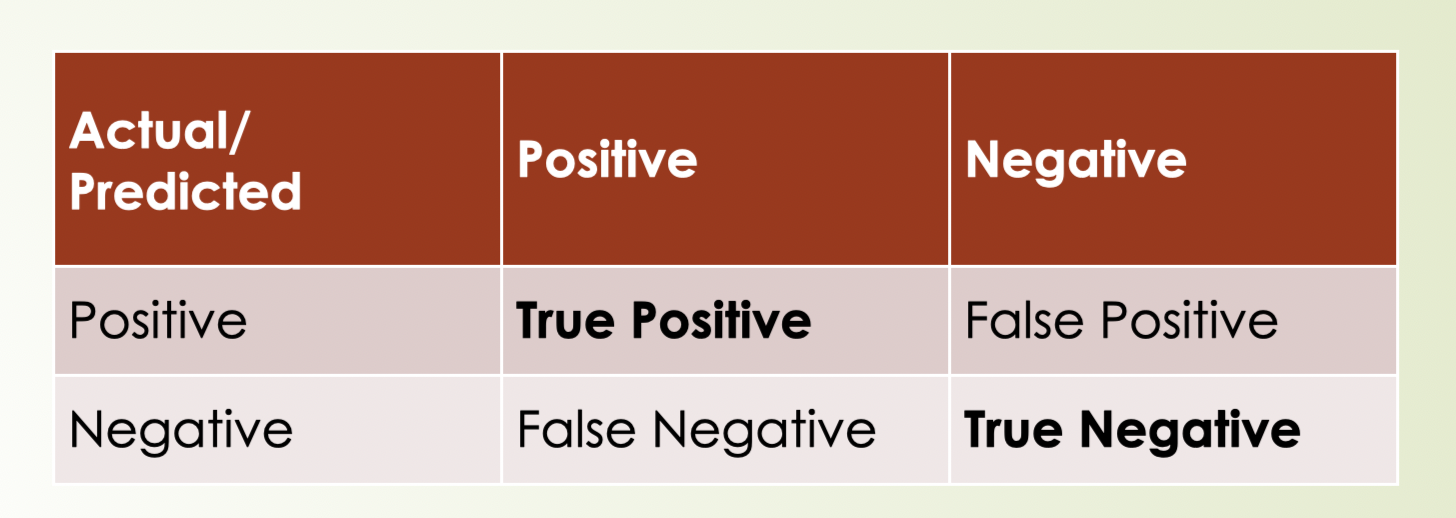

#### Classification Metrics

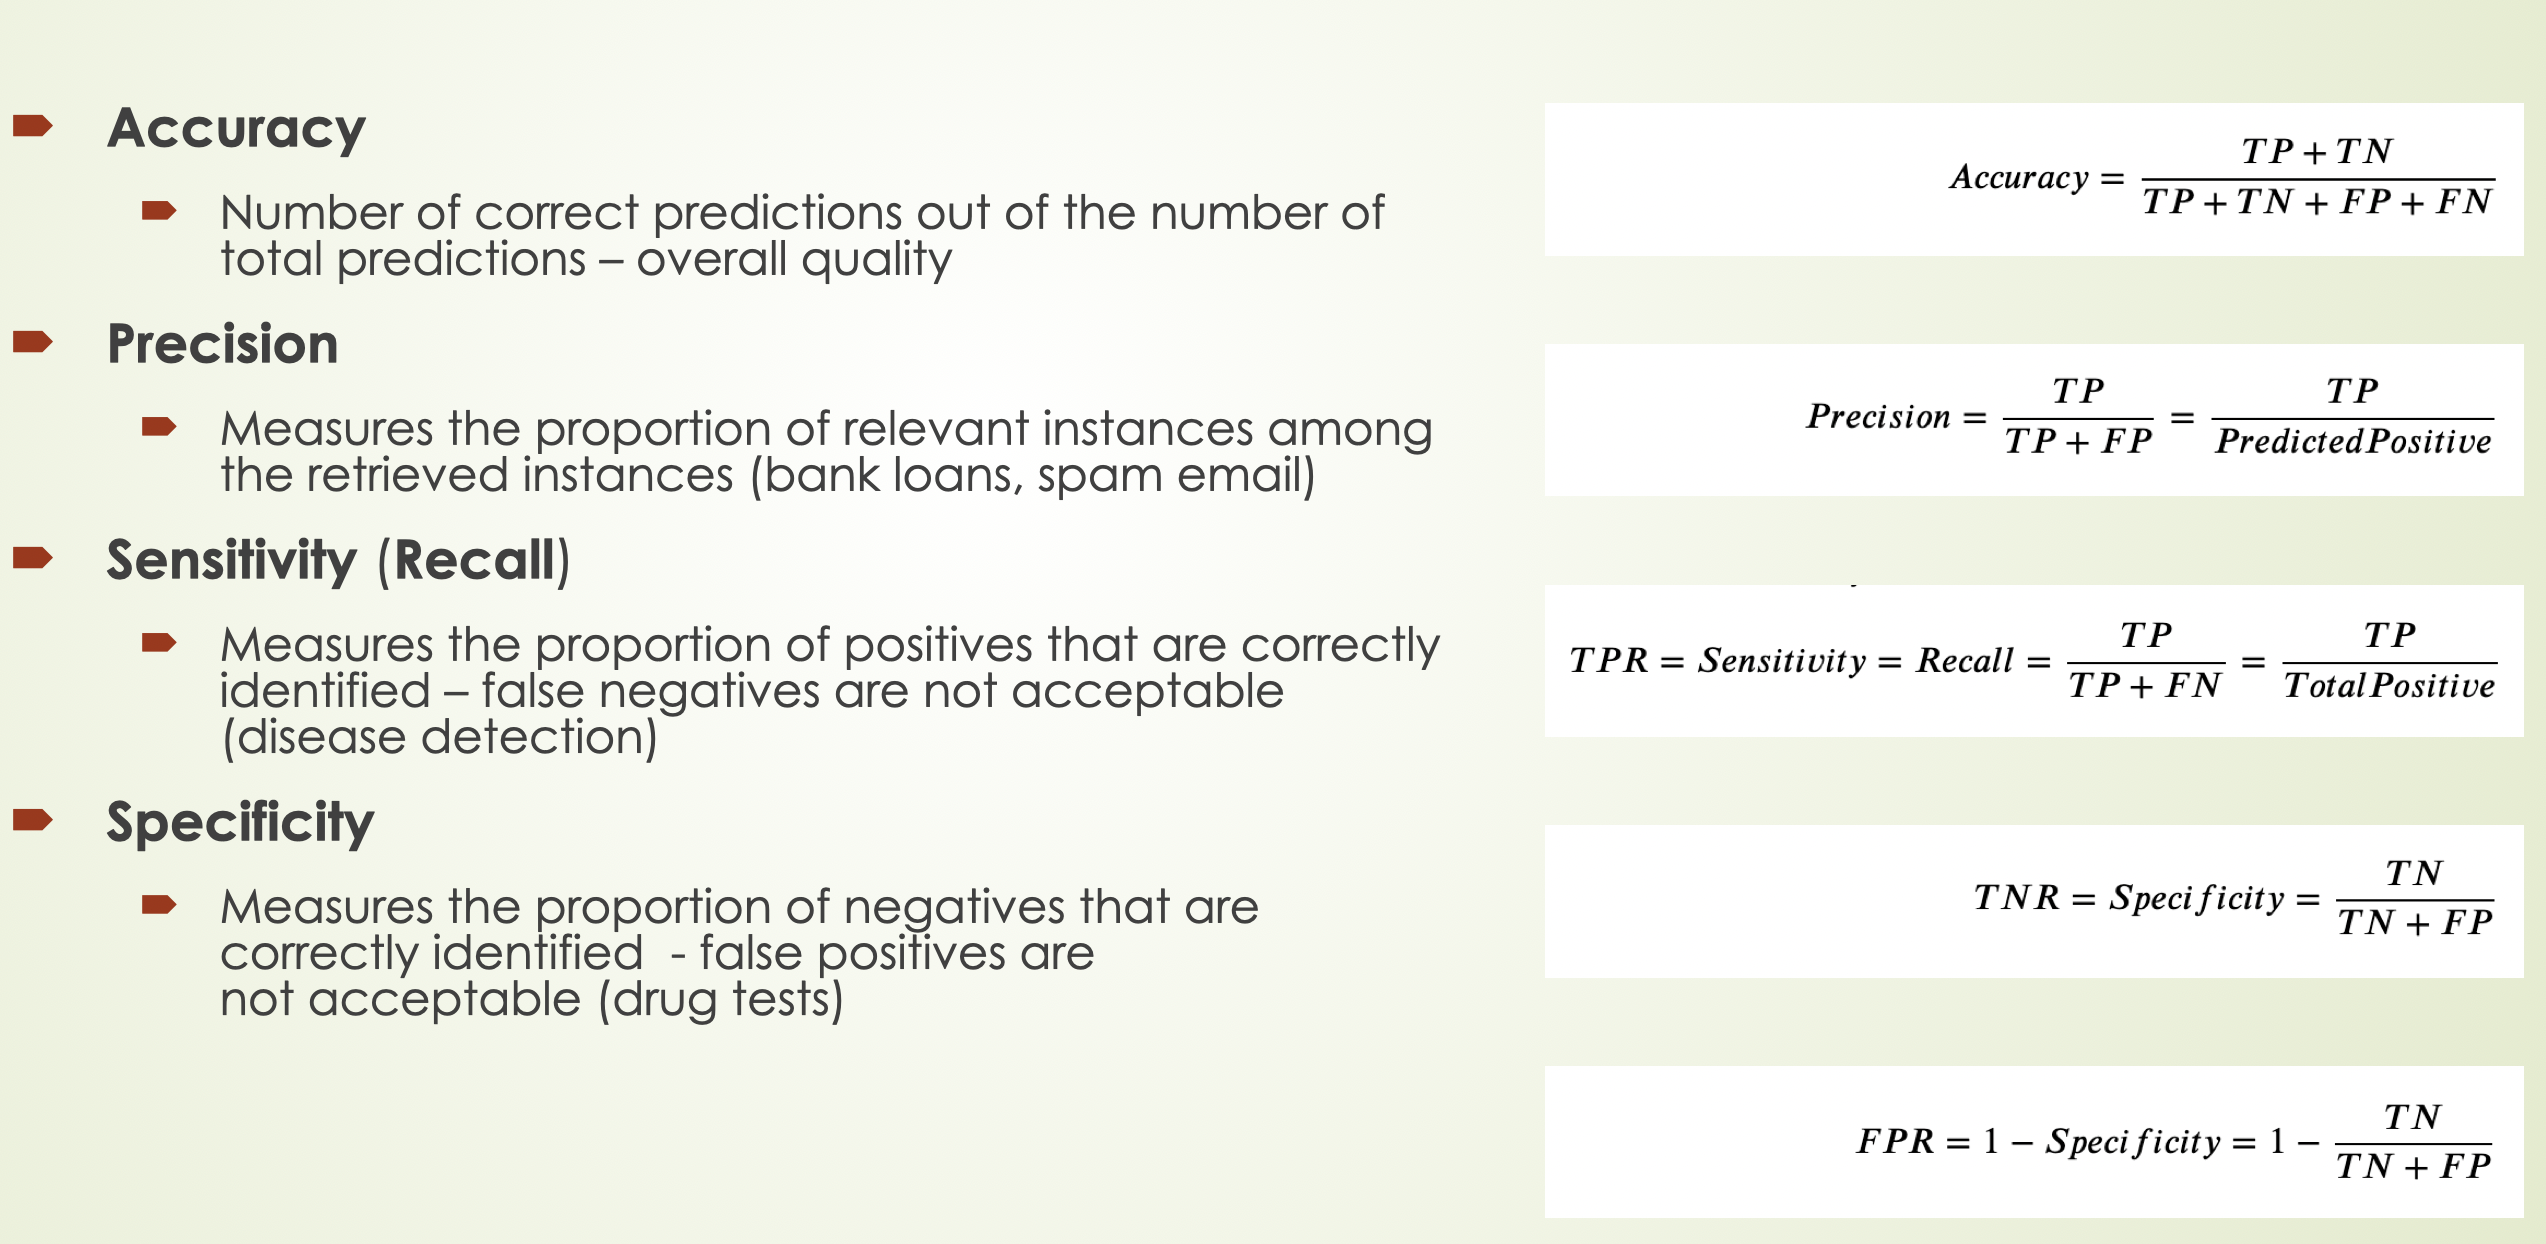

#### F1 Score

- harmonic mean of precision and recall
- better with imbalanced data

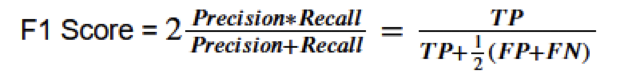

#### Precission - Recall Tradeoff

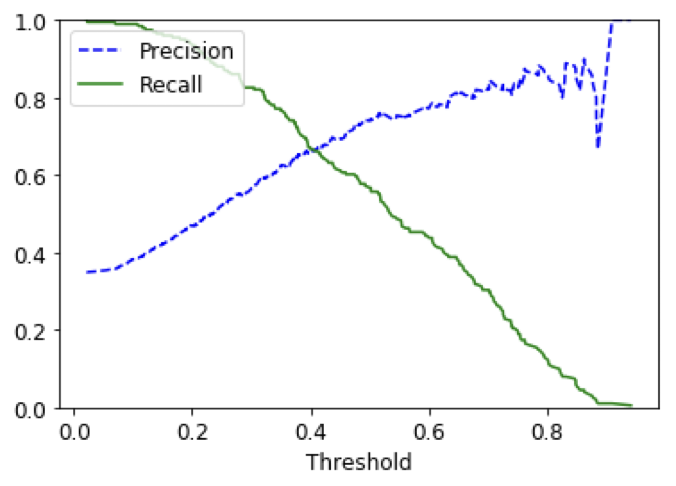

### ROC - AUC

- a high X-axis value = more False Positives than True Negatives. 
- a high Y-axis value = more True Positives than False Negatives

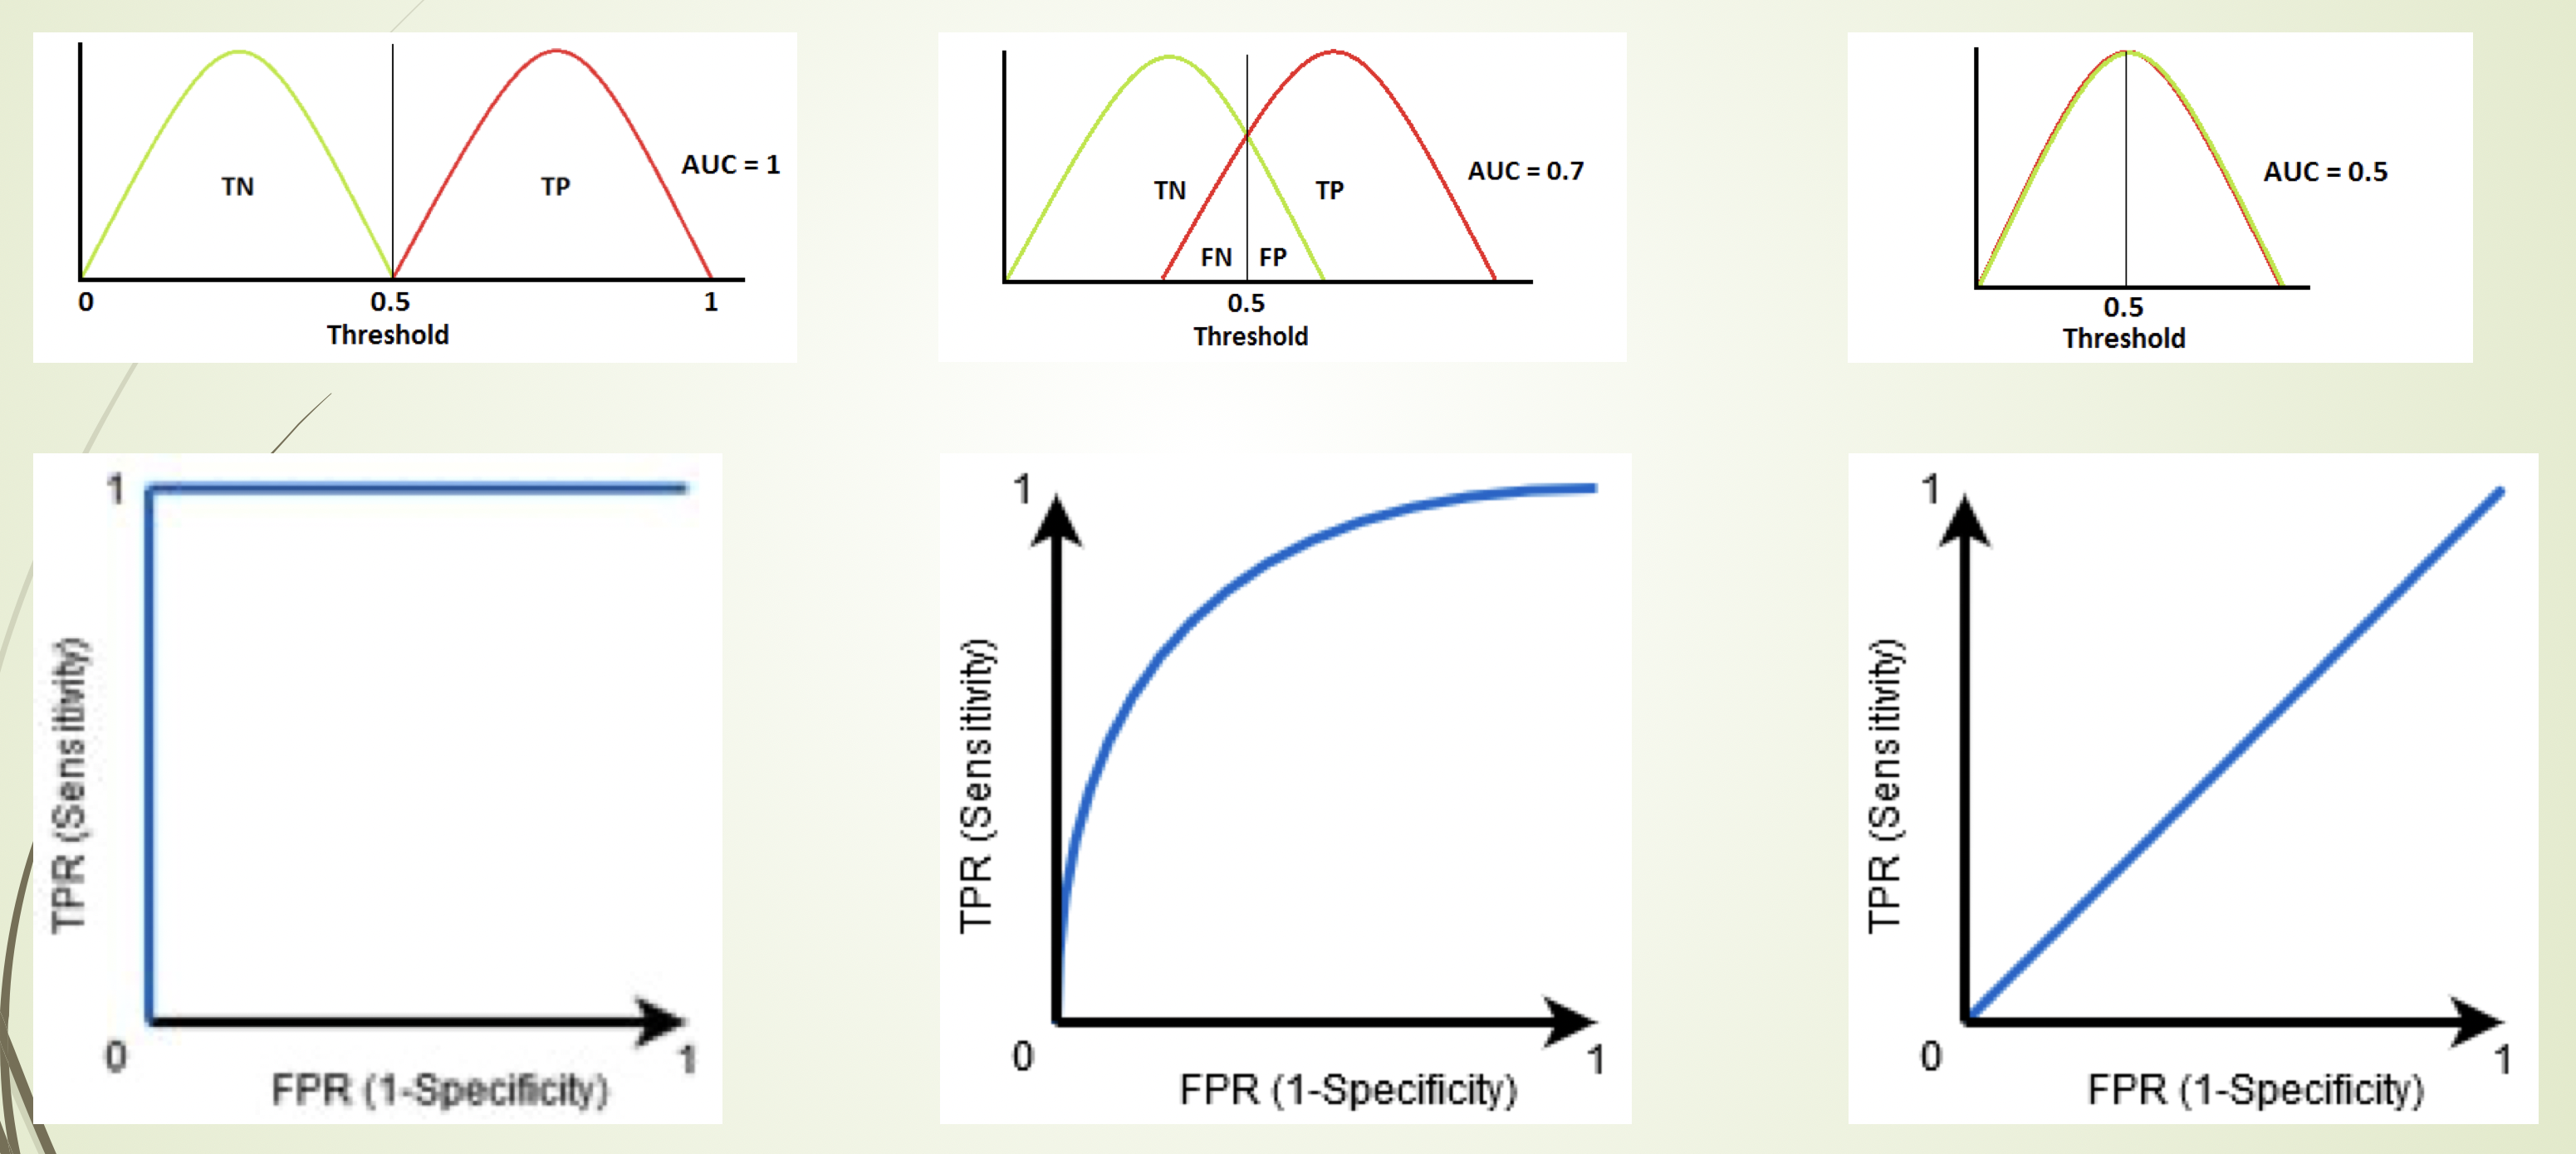

In [ ]:
def display_metrics(model, prediction, y_test, columns = None):
    print(classification_report(y_test, prediction, target_names = ['Not Fraud', 'Fraud']))
    
    ConfusionMatrixDisplay.from_predictions(y_test, prediction, labels=[0, 1])
    RocCurveDisplay.from_predictions(y_test, prediction)

    if hasattr(model, 'feature_importances_'):
        featureI = pd.DataFrame({
            'Feature': columns,
            'Importance': model.feature_importances_
        })
        featureI.sort_values('Importance', ascending=False, inplace=True)
        display(featureI.head(10))

### Logistic Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_minmax.copy(), 
                                                    y_fraud, 
                                                    test_size=0.2, 
                                                    random_state=42)

                                                    
print(f"Number of examples used for training : {X_train.shape[0]}")
print(f"Number of examples used for validation: {X_test.shape[0]}")

In [ ]:
lgmodel = LogisticRegression(class_weight="balanced", n_jobs = -1, random_state = 101, max_iter=10000)

%time lgmodel.fit(X_train, y_train)
%time prediction = lgmodel.predict(X_test)

In [ ]:
display_metrics(lgmodel, prediction, y_test)

#### Examine Model Coefficients

In [ ]:
model_coeff = pd.DataFrame(X_train.columns, columns = ["feature"])
model_coeff["coefficient"] = lgmodel.coef_[0]
model_coeff = model_coeff.sort_values(by = ["coefficient"], ascending=False)
 
plt.figure(figsize=(15, 25))
sns.barplot(x=model_coeff.coefficient, y=model_coeff.feature)
plt.show()

### Decission Trees

- using OHE is not recommended for decission trees
- Decission Trees are prone to overfitting

In [ ]:
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42
)

In [ ]:
dtc = DecisionTreeClassifier()
%time dtc.fit(X_train_tree, y_train_tree)
%time prediction = dtc.predict(X_test_tree)

display_metrics(dtc, prediction, y_test_tree, X_train_tree.columns)

### Ensemble Models 

- counter overfitting to give better results
- optimization is critical
- XGBoost: https://blog.paperspace.com/implementing-gradient-boosting-regression-python/

https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster

In [ ]:
xgbc = XGBClassifier(
    random_state = 42,
    scale_pos_weight = 20,
    use_label_encoder = False,
    eval_metric = 'logloss',
    objective = 'binary:logistic', 
    max_depth = 4, # try with 3 
    reg_alpha = 0.3,
    gamma = 6, # try with 6
#     learning_rate=0.1, 
#     subsample = 0.5
)

%time xgbc.fit(X_train_tree, y_train_tree)
%time prediction = xgbc.predict(X_test_tree)

display_metrics(xgbc, prediction, y_test_tree, X_train_tree.columns)

### Cross Validation

https://scikit-learn.org/stable/modules/cross_validation.html

In [ ]:
def print_cv_scores(alg, cv_scores):
    print(alg)
    print(cv_scores)
    print("Mean: {0} STD: {1}".format(cv_scores.mean(), cv_scores.std()))
    print(" ")

In [ ]:
from sklearn.model_selection import cross_val_score
xgbc_scores = cross_val_score(xgbc, X=X_encoded, y=y_encoded, cv=5)

lg_scores = cross_val_score(lgmodel, X=df_minmax, y=y_fraud, cv=5)

In [ ]:
print_cv_scores( "XGBoost", xgbc_scores)
print_cv_scores("Logistic Regression", lg_scores)

In [ ]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5)
kfold_scores = cross_val_score(xgbc, X=X_encoded, y=y_encoded, cv=kfold)

# for train, test in kfold.split(df_encoded):
#      print("%s %s" % (train, test))
              
print_cv_scores( "XGBoost with KFold", kfold_scores)

In [ ]:
from sklearn.model_selection import StratifiedKFold

strat_kfold = StratifiedKFold(n_splits=5)
strat_kfold_scores = cross_val_score(xgbc, X=X_encoded, y=y_encoded, cv=strat_kfold)

print_cv_scores( "XGBoost with Stratified KFold", strat_kfold_scores)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_ksplit = StratifiedShuffleSplit(n_splits=5)
strat_ksplit_scores = cross_val_score(xgbc, X=X_encoded, y=y_encoded, cv=strat_ksplit)

# for train, test in kfold.split(df_encoded):
#      print("%s %s" % (train, test))
print_cv_scores( "XGBoost with StratifiedShuffleSplit", strat_ksplit_scores)

#### Multiple Scores

In [ ]:
from sklearn.model_selection import cross_validate

# from sklearn import metrics
# print(sorted(metrics.SCORERS.keys()))

scores = cross_validate(xgbc, 
                        X=X_encoded, 
                        y=y_encoded, 
                        cv=5,
                        scoring=('f1_macro', 'accuracy', 'precision', 'recall', 'roc_auc'),
                        return_train_score=True)

scores

### Hyper Paramater Optimization

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': range(3, 7), 
    'gamma': range(1, 5),
#     'reg_alpha': (0.1, 0.2, 0.3, 0.4, 0.5),
#     'learning_rate': (0.01, 0.05, 0.1)
}
    
xgbc_cv = XGBClassifier(
    random_state = 42,
    scale_pos_weight = 20,
    use_label_encoder = False,
    eval_metric = 'logloss',
    objective = 'binary:logistic')
    
clf = GridSearchCV(estimator=xgbc_cv, 
                   param_grid=param_grid,
                  cv=5,
                  verbose=3)
clf.fit(X_train_tree, y_train_tree)

#results dataframe
df_cv_results = pd.DataFrame(clf.cv_results_)
df_cv_results.sort_values(by="rank_test_score", ascending=True)

# Summary

- load data using Pandas
- vizualize the data and it's properties
- select the data to use 
- clean and prepare the features for the model
- split the data in training and test subsets
- train the model
- asses the model performance on the test dataset
- try other algorithms
- fine tune the algorithm